# Deep Chemometrics Example, EMSC only
This is an example of how to build a simple convolutional neural network (CNN) to build predictive models from spectroscopical data (Deep Chemometrics). The dataset consists of NIR measurements of pharmaceutical tablets together with information about content of the active ingredients measured in the laboratory. We will use deep learning technology together with spectroscopical data augmentation to build a predictive model. The background and concept is further described in the preprint which can be downloaded free of charge from https://arxiv.org/pdf/1710.01927.pdf and also featuring in the blog post: https://www.wildcardconsulting.dk/useful-information/deep-chemometrics-deep-learning-for-spectroscopy/

In this example we baseline correct with EMSC instead of using data augmentation (See other example ipynb)

## Dataset
The dataset can be downloaded from http://www.eigenvector.com/data/tablets/index.html and should be placed in the Dataset folder. It is a MATLAB format file, but using the scipy.io module, it can be loaded into Python

In [39]:
import scipy.io as sio
import numpy as np

def get_xY(filename, maxx=600):
    
    #sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = matcontents.keys()
    for key in list(keys):
        if key[0] == '_':
            keys.remove(key)
            
    keys.sort()
            
    d = {}            
    for key in keys:
        data = matcontents[key][0][0]
        if key[-1] == "Y":
            Ydata = data[5]
            d[key] = Ydata
        else:
            xdata = data[5][:,:maxx]
            d[key] = xdata
            d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

filename = 'Dataset/nir_shootout_2002.mat'
dataset = get_xY(filename)

In [40]:
dataset.keys()

['validate_1',
 'validate_2',
 'validate_Y',
 'test_Y',
 'calibrate_Y',
 'test_2',
 'test_1',
 'calibrate_1',
 'axisscale',
 'calibrate_2']

1.0000000000000002
-4.6133789220365925e-17
4.016602295406501


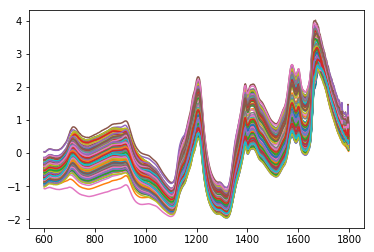

In [41]:
#Rescale to NN friendly number range
import matplotlib.pyplot as plt
%matplotlib inline

from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

X_train = xscaler.fit_transform(dataset['test_1'])
X_test = xscaler.transform(dataset['calibrate_2'])

print X_train.std()
print X_train.mean()
print X_train.max()
_ = plt.plot(dataset['axisscale'],X_train.T)

In [42]:
yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform(dataset['test_Y'][:,2])
y_test = yscaler.transform(dataset['calibrate_Y'][:,2]) 

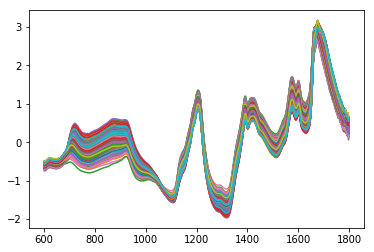

In [43]:
#EMSC rescaling
from ChemUtils import EmscScaler

emsc = EmscScaler()

emsc.fit(X_train)

X_train_emsc = emsc.transform(X_train)
_ = plt.plot(dataset['axisscale'],X_train_emsc.T)

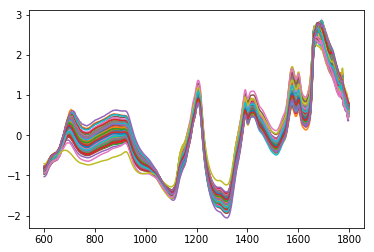

In [44]:
#Tranforming the test set
X_test = xscaler.transform(dataset['calibrate_2'])
X_test_emsc = emsc.transform(X_test)

_ = plt.plot(dataset['axisscale'],X_test_emsc.T)

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape#, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise

In [46]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32

activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, border_mode="same"))
    model.add(Conv1D(C2_K, (C2_S), border_mode="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [47]:
model = make_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_4 (GaussianNo (None, 600)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 600, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 600, 8)            264       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 600, 16)           4112      
_________________________________________________________________
flatten_4 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1228928   
__________

/home/esben/.virtualenvs/keras2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(8, 32, padding="same", activation="relu")`
/home/esben/.virtualenvs/keras2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(16, 32, padding="same", activation="relu")`


We need higher "patience" and number of epochs as the training set lenght is much smaller wihout data augmentation

In [48]:
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train_emsc, y_train, epochs=600, batch_size=8, validation_data=(X_test_emsc, y_test), callbacks=[rdlr])

Train on 460 samples, validate on 155 samples
Epoch 1/600
460/460 [==============================] - 1s 2ms/step - loss: 1.0579 - val_loss: 1.9352
Epoch 2/600
460/460 [==============================] - 0s 712us/step - loss: 1.0425 - val_loss: 1.9280
Epoch 3/600
460/460 [==============================] - 0s 696us/step - loss: 0.9954 - val_loss: 1.8913
Epoch 4/600
460/460 [==============================] - 0s 706us/step - loss: 0.9896 - val_loss: 1.8599
Epoch 5/600
460/460 [==============================] - 0s 703us/step - loss: 0.9803 - val_loss: 1.8550
Epoch 6/600
460/460 [==============================] - 0s 698us/step - loss: 0.9798 - val_loss: 1.8460
Epoch 7/600
460/460 [==============================] - 0s 713us/step - loss: 0.9560 - val_loss: 1.8541
Epoch 8/600
460/460 [==============================] - 0s 746us/step - loss: 0.9144 - val_loss: 1.8522
Epoch 9/600
460/460 [==============================] - 0s 696us/step - loss: 0.9112 - val_loss: 1.8123
Epoch 10/600
460/460 [=======

460/460 [==============================] - 0s 701us/step - loss: 0.5978 - val_loss: 1.1570
Epoch 80/600
460/460 [==============================] - 0s 700us/step - loss: 0.5532 - val_loss: 1.0828
Epoch 81/600
460/460 [==============================] - 0s 732us/step - loss: 0.5880 - val_loss: 1.1781
Epoch 82/600
460/460 [==============================] - 0s 702us/step - loss: 0.5948 - val_loss: 1.1127
Epoch 83/600
460/460 [==============================] - 0s 705us/step - loss: 0.5650 - val_loss: 1.1544
Epoch 84/600
460/460 [==============================] - 0s 705us/step - loss: 0.5757 - val_loss: 1.1253
Epoch 85/600
460/460 [==============================] - 0s 710us/step - loss: 0.5584 - val_loss: 1.0273
Epoch 86/600
460/460 [==============================] - 0s 702us/step - loss: 0.5467 - val_loss: 1.1277
Epoch 87/600
460/460 [==============================] - 0s 704us/step - loss: 0.5265 - val_loss: 1.0618
Epoch 88/600
460/460 [==============================] - 0s 768us/step - loss:

460/460 [==============================] - 0s 717us/step - loss: 0.2973 - val_loss: 0.4790
Epoch 158/600
460/460 [==============================] - 0s 707us/step - loss: 0.2876 - val_loss: 0.5675
Epoch 159/600
460/460 [==============================] - 0s 703us/step - loss: 0.2798 - val_loss: 0.5676
Epoch 160/600
460/460 [==============================] - 0s 702us/step - loss: 0.2841 - val_loss: 0.5045
Epoch 161/600
460/460 [==============================] - 0s 722us/step - loss: 0.2968 - val_loss: 0.4612
Epoch 162/600
460/460 [==============================] - 0s 726us/step - loss: 0.2790 - val_loss: 0.5196
Epoch 163/600
460/460 [==============================] - 0s 703us/step - loss: 0.2784 - val_loss: 0.4881
Epoch 164/600
460/460 [==============================] - 0s 697us/step - loss: 0.2668 - val_loss: 0.4535
Epoch 165/600
460/460 [==============================] - 0s 697us/step - loss: 0.2838 - val_loss: 0.4857
Epoch 166/600
460/460 [==============================] - 0s 704us/ste

460/460 [==============================] - 0s 730us/step - loss: 0.1945 - val_loss: 0.3115
Epoch 236/600
460/460 [==============================] - 0s 712us/step - loss: 0.1867 - val_loss: 0.3041
Epoch 237/600
460/460 [==============================] - 0s 702us/step - loss: 0.1931 - val_loss: 0.2276
Epoch 238/600
460/460 [==============================] - 0s 698us/step - loss: 0.1816 - val_loss: 0.3466
Epoch 239/600
460/460 [==============================] - 0s 700us/step - loss: 0.1866 - val_loss: 0.2878
Epoch 240/600
460/460 [==============================] - 0s 699us/step - loss: 0.1923 - val_loss: 0.3366
Epoch 241/600
460/460 [==============================] - 0s 694us/step - loss: 0.1794 - val_loss: 0.2597
Epoch 242/600
460/460 [==============================] - 0s 751us/step - loss: 0.1718 - val_loss: 0.2912
Epoch 243/600
460/460 [==============================] - 0s 697us/step - loss: 0.2059 - val_loss: 0.2482
Epoch 244/600
460/460 [==============================] - 0s 699us/ste

460/460 [==============================] - 0s 699us/step - loss: 0.1501 - val_loss: 0.2361
Epoch 314/600
460/460 [==============================] - 0s 702us/step - loss: 0.1778 - val_loss: 0.2054
Epoch 315/600
460/460 [==============================] - 0s 719us/step - loss: 0.1653 - val_loss: 0.1444
Epoch 316/600
460/460 [==============================] - 0s 738us/step - loss: 0.1586 - val_loss: 0.2296
Epoch 317/600
460/460 [==============================] - 0s 698us/step - loss: 0.1611 - val_loss: 0.2302
Epoch 318/600
460/460 [==============================] - 0s 692us/step - loss: 0.1757 - val_loss: 0.2209
Epoch 319/600
460/460 [==============================] - 0s 698us/step - loss: 0.1569 - val_loss: 0.1844
Epoch 320/600
460/460 [==============================] - 0s 700us/step - loss: 0.1442 - val_loss: 0.2374
Epoch 321/600
460/460 [==============================] - 0s 697us/step - loss: 0.1503 - val_loss: 0.1964
Epoch 322/600
460/460 [==============================] - 0s 733us/ste

Epoch 389/600
460/460 [==============================] - 0s 739us/step - loss: 0.1413 - val_loss: 0.1994
Epoch 390/600
460/460 [==============================] - 0s 703us/step - loss: 0.1487 - val_loss: 0.2015
Epoch 391/600
408/460 [=========================>....] - ETA: 0s - loss: 0.1484
Epoch 00391: reducing learning rate to 0.00124999997206.
460/460 [==============================] - 0s 705us/step - loss: 0.1434 - val_loss: 0.1967
Epoch 392/600
460/460 [==============================] - 0s 702us/step - loss: 0.1481 - val_loss: 0.1896
Epoch 393/600
460/460 [==============================] - 0s 702us/step - loss: 0.1503 - val_loss: 0.1923
Epoch 394/600
460/460 [==============================] - 0s 697us/step - loss: 0.1632 - val_loss: 0.1891
Epoch 395/600
460/460 [==============================] - 0s 718us/step - loss: 0.1520 - val_loss: 0.1908
Epoch 396/600
460/460 [==============================] - 0s 719us/step - loss: 0.1385 - val_loss: 0.2006
Epoch 397/600
460/460 [==============

460/460 [==============================] - 0s 726us/step - loss: 0.1491 - val_loss: 0.1892
Epoch 464/600
460/460 [==============================] - 0s 702us/step - loss: 0.1331 - val_loss: 0.1901
Epoch 465/600
460/460 [==============================] - 0s 724us/step - loss: 0.1535 - val_loss: 0.1911
Epoch 466/600
408/460 [=========================>....] - ETA: 0s - loss: 0.1097
Epoch 00466: reducing learning rate to 0.000156249996508.
460/460 [==============================] - 0s 701us/step - loss: 0.1323 - val_loss: 0.1932
Epoch 467/600
460/460 [==============================] - 0s 697us/step - loss: 0.1481 - val_loss: 0.1932
Epoch 468/600
460/460 [==============================] - 0s 698us/step - loss: 0.1521 - val_loss: 0.1945
Epoch 469/600
460/460 [==============================] - 0s 744us/step - loss: 0.1423 - val_loss: 0.1928
Epoch 470/600
460/460 [==============================] - 0s 731us/step - loss: 0.1582 - val_loss: 0.1943
Epoch 471/600
460/460 [===========================

460/460 [==============================] - 0s 702us/step - loss: 0.1441 - val_loss: 0.1957
Epoch 538/600
460/460 [==============================] - 0s 709us/step - loss: 0.1525 - val_loss: 0.1956
Epoch 539/600
460/460 [==============================] - 0s 731us/step - loss: 0.1407 - val_loss: 0.1957
Epoch 540/600
460/460 [==============================] - 0s 703us/step - loss: 0.1460 - val_loss: 0.1954
Epoch 541/600
408/460 [=========================>....] - ETA: 0s - loss: 0.1264
Epoch 00541: reducing learning rate to 1.95312495634e-05.
460/460 [==============================] - 0s 704us/step - loss: 0.1501 - val_loss: 0.1952
Epoch 542/600
460/460 [==============================] - 0s 711us/step - loss: 0.1521 - val_loss: 0.1952
Epoch 543/600
460/460 [==============================] - 0s 729us/step - loss: 0.1608 - val_loss: 0.1952
Epoch 544/600
460/460 [==============================] - 0s 698us/step - loss: 0.1383 - val_loss: 0.1952
Epoch 545/600
460/460 [===========================

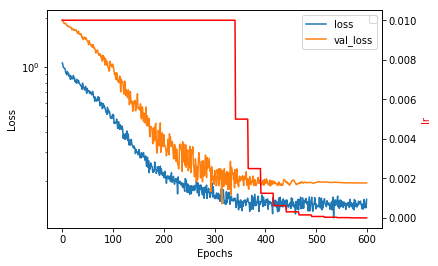

In [49]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

_ = plt.legend()

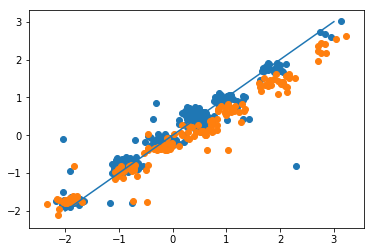

In [50]:
plt.scatter(y_train, model.predict(X_train_emsc))
plt.scatter(y_test, model.predict(X_test_emsc))
plt.plot([-2,3],[-2,3]) # Y = PredY line

In [53]:
#Some metrics

def huber(y_true, y_pred, delta=1.0):
	y_true = y_true.reshape(-1,1)
	y_pred = y_pred.reshape(-1,1)
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

In [54]:
def benchmark(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - model.predict(X_train).reshape(y_train.shape))**2)**0.5
    rmse_test = np.mean((y_test - model.predict(X_test).reshape(y_test.shape))**2)**0.5
    hub = huber(y_train, model.predict(X_train))
    hub_test = huber(y_test, model.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [55]:
benchmark(X_train_emsc, y_train, X_test_emsc, y_test, model)

RMSE  Train/Test	0.27	0.44
Huber Train/Test	0.0275	0.0863


Compare the performance with the one using data augmentation. However, experimenting with tuning the hyperparameters can improve both models. In the preprint and systematic tuning, a combination of data augementation and EMSC worked the best.